In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scipy
from scipy.stats import multivariate_normal as n_mvn
import corner
import torch
import warnings
import pickle

import torch.distributions
from nfmc_jax.DLA.base import PPDLMC, LatentDLA
from nfmc_jax.DLA.posterior import TorchPosterior
from nfmc_jax.DLA.debug import MultiStageDebugger
from nfmc_jax.flows.base import SINFInterface, RealNVPInterface, MAFInterface, RQNSFInterface, PPInterface
from nfmc_jax.utils.torch_distributions import gaussian_log_prob, Funnel

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Sampling a 100-d noisy funnel

In [2]:
D = 100 # Latent variable dimensions (not NF latent space)
a = 3.
b = 0.5

theta_sample = 0
z_sample = torch.randn((D,))
z_sample = z_sample * np.exp(b * theta_sample)
data_sample = torch.distributions.MultivariateNormal(loc=z_sample, 
                                                     covariance_matrix=5.0**2*torch.eye(D)).sample()
print(data_sample.shape)

def log_like(x, data=data_sample):
    theta = x[:, 0]
    z = x[:, 1:]
    return torch.distributions.MultivariateNormal(loc=data,
                                                  covariance_matrix=5.0**2*torch.eye(D)).log_prob(z)
    
def log_prior(x):
    theta = x[:, 0]
    z = x[:, 1:]
    log_pi_theta = torch.distributions.Normal(loc=0, scale=a).log_prob(theta)
    mu_z = torch.zeros((z.shape[0], D))
    sd_z = torch.exp(b * theta).reshape(z.shape[0], 1) * torch.ones((z.shape[0], D))
    log_pi_z = torch.sum(torch.distributions.Normal(loc=mu_z, scale=sd_z).log_prob(z), dim=1)
    return log_pi_theta + log_pi_z

def prior_rvs(N, seed):
    torch.manual_seed(seed)
    n01 = torch.randn((N, D + 1))
    theta = n01[:, 0] * a
    z = torch.zeros((N, D))
    for i in range(N):
        z[i, :] = n01[i, 1:] * torch.exp(b * theta[i])
    x = torch.cat([theta.reshape(N, 1), z], dim=1)
    return x

posterior = TorchPosterior(log_likelihood = lambda x: log_like(x),
                           log_prior = lambda x: log_prior(x))

initial_samples = prior_rvs(2000, 0)

torch.Size([100])


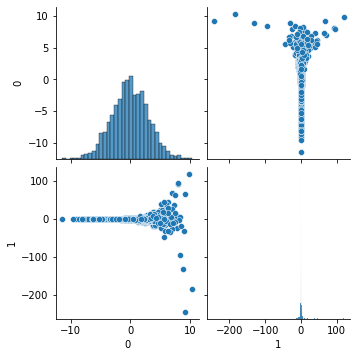

In [3]:
xdf = initial_samples[:, 0:2]
df = pd.DataFrame(xdf)
sns.pairplot(df)

In [4]:
idata = az.from_netcdf('./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/new_inference_data_funnel_non_centered_mcmc.nc')
itheta = idata['posterior']['theta'].to_numpy()
iz = idata['posterior']['z'].to_numpy()
iz.shape

ix = np.concatenate([itheta[0, :].reshape(10000, 1), iz[0, :, :]], axis=1)
ix.shape

nc_steps = idata['sample_stats']['n_steps'].to_numpy()[0]

In [5]:
# Remember you used 101 layers before.

flow_interface = SINFInterface()
flow_interface.create_flow(x=initial_samples,
                           val_frac=0.2,
                           iteration=None,
                           bounds=None,
                           alpha=(0., 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           K=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=True,
                           MSWD_max_iter=None)

/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/nfmc_jax/sinf/SINF.py:581: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  Q, R = torch.qr(ATi)


In [6]:
burnin_interface = SINFInterface()
burnin_interface.create_flow(x=initial_samples,
                             val_frac=0.2,
                           iteration=None,
                           bounds=None,
                           alpha=(0., 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=True,
                           MSWD_max_iter=None)

In [10]:
maf_interface = MAFInterface(n_dim=101, n_hidden=15, n_layers=10)
maf_interface.create_flow()

In [38]:
import pickle

#idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
idx = [3]

for i in idx:
    
    print(f'DLMC run {i}')
    
    initial_samples = prior_rvs(2000, seed=i)
    
    dlmc = LatentDLA(
    interface=flow_interface,
    burnin_interface=burnin_interface,
    posterior=posterior,
    debugger=None
    )

    xfi = dlmc.run(initial_samples,
              main_step=1e-4,
              burnin_step=1e-4,
              burnin_optimizer='grad_descent',
              optimizer='grad_descent',
              optim_scheduler='identity',
              exp_decay_rate=0.99,
              cos_T_max=100,
              cos_lr_min=0.0,
              burnin_optim_steps=1,
              optim_steps=1,
              atol=1e-15,
              max_burnin=100,
              burnin_thresh=1.01,
              num_upsample=0,
              max_iterations=10,
              latent=True,
              IMHstep=1,
              CMHstep=0,
              CMHscale=0.1,
              ULMstep=0,
              stochastic_calibration=False,
              taylor_zeta=True,
              use_tqdm=True,
              post_ulm_steps=0,
              post_ulm_batch=0,
              animate_kwargs=dict(dpi=200),
              train_kwargs={'val_frac': 0.2},
              underdamped_kwargs={'step_size':1.0e-3, 'gamma': 2.0}
              )
    
    '''
    with open(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/dlmc_run_{i}.pkl', 'wb') as f:
        pickle.dump(xfi, f)
    f.close()
    '''

DLMC run 3


  0%|                                                   | 0/110 [00:00<?, ?it/s]

zVirial = 260757.703125
Virial = 505.41314697265625
<sum_x_virial> = 505.41314697265625
<sum_z_virial> = 260757.703125


[Stage 0] Beta: 1.0:   1%|   | 1/110 [00:14<25:42, 14.15s/it, accept_IMH=0.0445]

zVirial = 31421.103515625
Virial = 216.8060302734375
<sum_x_virial> = 216.8060302734375
<sum_z_virial> = 31421.103515625


[Stage 0] Beta: 1.0:   2%|   | 2/110 [00:56<55:33, 30.87s/it, accept_IMH=0.0725]

zVirial = 8543.7822265625
Virial = 174.35726928710938
<sum_x_virial> = 174.35726928710938
<sum_z_virial> = 8543.7822265625


[Stage 0] Beta: 1.0:   3%|   | 3/110 [01:08<39:37, 22.22s/it, accept_IMH=0.0195]

zVirial = 990.1689453125
Virial = 149.25453186035156
<sum_x_virial> = 149.25453186035156
<sum_z_virial> = 990.1689453125


[Stage 0] Beta: 1.0:   4%|▏   | 4/110 [01:19<31:10, 17.65s/it, accept_IMH=0.014]

zVirial = 595.137451171875
Virial = 143.11492919921875
<sum_x_virial> = 143.11492919921875
<sum_z_virial> = 595.137451171875


[Stage 0] Beta: 1.0:   5%|▏  | 5/110 [01:30<26:33, 15.18s/it, accept_IMH=0.0165]

zVirial = 428.47802734375
Virial = 139.29757690429688
<sum_x_virial> = 139.29757690429688
<sum_z_virial> = 428.47802734375


[Stage 0] Beta: 1.0:   5%|▏  | 6/110 [01:42<24:35, 14.19s/it, accept_IMH=0.0145]

zVirial = 363.8388366699219
Virial = 132.69692993164062
<sum_x_virial> = 132.69692993164062
<sum_z_virial> = 363.8388366699219


[Stage 0] Beta: 1.0:   6%|▏  | 7/110 [01:54<23:01, 13.41s/it, accept_IMH=0.0115]

zVirial = 301.29107666015625
Virial = 127.9783935546875
<sum_x_virial> = 127.9783935546875
<sum_z_virial> = 301.29107666015625


[Stage 0] Beta: 1.0:   7%|▏  | 8/110 [02:03<20:42, 12.18s/it, accept_IMH=0.0105]

zVirial = 290.9722595214844
Virial = 126.77732849121094
<sum_x_virial> = 126.77732849121094
<sum_z_virial> = 290.9722595214844


[Stage 0] Beta: 1.0:   8%|▎   | 9/110 [02:13<19:12, 11.41s/it, accept_IMH=0.007]

zVirial = 288.0567626953125
Virial = 125.28145599365234
<sum_x_virial> = 125.28145599365234
<sum_z_virial> = 288.0567626953125


[Stage 0] Beta: 1.0:   9%|▎  | 10/110 [02:24<18:44, 11.25s/it, accept_IMH=0.009]

zVirial = 278.1336364746094
Virial = 124.14971160888672
<sum_x_virial> = 124.14971160888672
<sum_z_virial> = 278.1336364746094


[Stage 0] Beta: 1.0:  10%|▎  | 11/110 [02:36<18:56, 11.48s/it, accept_IMH=0.009]

zVirial = 279.61737060546875
Virial = 122.97355651855469
<sum_x_virial> = 122.97355651855469
<sum_z_virial> = 279.61737060546875


[Stage 0] Beta: 1.0:  11%|▎  | 12/110 [02:47<18:23, 11.26s/it, accept_IMH=0.007]

zVirial = 250.1501007080078
Virial = 123.04781341552734
<sum_x_virial> = 123.04781341552734
<sum_z_virial> = 250.1501007080078


[Stage 0] Beta: 1.0:  12%|▏ | 13/110 [02:56<17:20, 10.73s/it, accept_IMH=0.0055]

zVirial = 249.38873291015625
Virial = 122.3604507446289
<sum_x_virial> = 122.3604507446289
<sum_z_virial> = 249.38873291015625


[Stage 0] Beta: 1.0:  13%|▎ | 14/110 [03:06<16:58, 10.61s/it, accept_IMH=0.0075]

zVirial = 267.56982421875
Virial = 121.05640411376953
<sum_x_virial> = 121.05640411376953
<sum_z_virial> = 267.56982421875


[Stage 0] Beta: 1.0:  14%|▍  | 15/110 [03:17<16:58, 10.72s/it, accept_IMH=0.008]

zVirial = 235.46658325195312
Virial = 120.40995788574219
<sum_x_virial> = 120.40995788574219
<sum_z_virial> = 235.46658325195312


[Stage 0] Beta: 1.0:  15%|▍  | 16/110 [03:28<16:30, 10.54s/it, accept_IMH=0.005]

zVirial = 239.99691772460938
Virial = 119.48809814453125
<sum_x_virial> = 119.48809814453125
<sum_z_virial> = 239.99691772460938


[Stage 0] Beta: 1.0:  15%|▍  | 17/110 [03:38<16:15, 10.49s/it, accept_IMH=0.005]

zVirial = 246.62953186035156
Virial = 118.23726654052734
<sum_x_virial> = 118.23726654052734
<sum_z_virial> = 246.62953186035156


[Stage 0] Beta: 1.0:  16%|▍  | 18/110 [03:49<16:20, 10.65s/it, accept_IMH=0.004]

zVirial = 211.11282348632812
Virial = 117.97283172607422
<sum_x_virial> = 117.97283172607422
<sum_z_virial> = 211.11282348632812


[Stage 0] Beta: 1.0:  17%|▌  | 19/110 [03:57<15:08,  9.98s/it, accept_IMH=0.002]

zVirial = 211.64471435546875
Virial = 117.25912475585938
<sum_x_virial> = 117.25912475585938
<sum_z_virial> = 211.64471435546875


[Stage 0] Beta: 1.0:  18%|▌  | 20/110 [04:06<14:30,  9.67s/it, accept_IMH=0.003]

zVirial = 242.0576171875
Virial = 116.78057098388672
<sum_x_virial> = 116.78057098388672
<sum_z_virial> = 242.0576171875


[Stage 0] Beta: 1.0:  19%|▍ | 21/110 [04:17<14:47,  9.97s/it, accept_IMH=0.0035]

zVirial = 206.38900756835938
Virial = 116.71204376220703
<sum_x_virial> = 116.71204376220703
<sum_z_virial> = 206.38900756835938


[Stage 0] Beta: 1.0:  20%|▍ | 22/110 [04:25<13:56,  9.51s/it, accept_IMH=0.0015]

zVirial = 215.22543334960938
Virial = 116.46135711669922
<sum_x_virial> = 116.46135711669922
<sum_z_virial> = 215.22543334960938


[Stage 0] Beta: 1.0:  21%|▍ | 23/110 [04:35<13:41,  9.44s/it, accept_IMH=0.0035]

zVirial = 206.3574676513672
Virial = 116.17576599121094
<sum_x_virial> = 116.17576599121094
<sum_z_virial> = 206.3574676513672


[Stage 0] Beta: 1.0:  22%|▍ | 24/110 [04:44<13:27,  9.39s/it, accept_IMH=0.0025]

zVirial = 207.96685791015625
Virial = 115.90065002441406
<sum_x_virial> = 115.90065002441406
<sum_z_virial> = 207.96685791015625


[Stage 0] Beta: 1.0:  23%|▋  | 25/110 [04:53<13:17,  9.39s/it, accept_IMH=0.004]

zVirial = 212.1659698486328
Virial = 115.57861328125
<sum_x_virial> = 115.57861328125
<sum_z_virial> = 212.1659698486328


[Stage 0] Beta: 1.0:  24%|▋  | 26/110 [05:03<13:09,  9.40s/it, accept_IMH=0.005]

zVirial = 210.72088623046875
Virial = 115.2496109008789
<sum_x_virial> = 115.2496109008789
<sum_z_virial> = 210.72088623046875


[Stage 0] Beta: 1.0:  25%|▍ | 27/110 [05:13<13:22,  9.67s/it, accept_IMH=0.0015]

zVirial = 212.24571228027344
Virial = 115.123779296875
<sum_x_virial> = 115.123779296875
<sum_z_virial> = 212.24571228027344


[Stage 0] Beta: 1.0:  25%|▌ | 28/110 [05:24<13:37,  9.97s/it, accept_IMH=0.0025]

zVirial = 211.0664825439453
Virial = 115.00981903076172
<sum_x_virial> = 115.00981903076172
<sum_z_virial> = 211.0664825439453


[Stage 0] Beta: 1.0:  26%|▊  | 29/110 [05:33<13:21,  9.90s/it, accept_IMH=0.003]

zVirial = 214.49961853027344
Virial = 114.96760559082031
<sum_x_virial> = 114.96760559082031
<sum_z_virial> = 214.49961853027344


[Stage 0] Beta: 1.0:  27%|▌ | 30/110 [05:44<13:22, 10.04s/it, accept_IMH=0.0045]

zVirial = 198.07769775390625
Virial = 114.72891998291016
<sum_x_virial> = 114.72891998291016
<sum_z_virial> = 198.07769775390625


[Stage 0] Beta: 1.0:  28%|▌ | 31/110 [05:53<12:59,  9.87s/it, accept_IMH=0.0005]

zVirial = 206.6632843017578
Virial = 114.68276977539062
<sum_x_virial> = 114.68276977539062
<sum_z_virial> = 206.6632843017578


[Stage 0] Beta: 1.0:  29%|▊  | 32/110 [06:04<13:18, 10.24s/it, accept_IMH=0.002]

zVirial = 205.46343994140625
Virial = 114.59517669677734
<sum_x_virial> = 114.59517669677734
<sum_z_virial> = 205.46343994140625


[Stage 0] Beta: 1.0:  30%|▌ | 33/110 [06:15<13:15, 10.33s/it, accept_IMH=0.0015]

zVirial = 197.52398681640625
Virial = 114.56890869140625
<sum_x_virial> = 114.56890869140625
<sum_z_virial> = 197.52398681640625


[Stage 0] Beta: 1.0:  31%|▉  | 34/110 [06:25<13:03, 10.30s/it, accept_IMH=0.001]

zVirial = 197.87454223632812
Virial = 114.49198150634766
<sum_x_virial> = 114.49198150634766
<sum_z_virial> = 197.87454223632812


[Stage 0] Beta: 1.0:  32%|▉  | 35/110 [06:35<12:50, 10.28s/it, accept_IMH=0.002]

zVirial = 214.9353790283203
Virial = 114.50743865966797
<sum_x_virial> = 114.50743865966797
<sum_z_virial> = 214.9353790283203


[Stage 0] Beta: 1.0:  33%|▋ | 36/110 [06:47<13:12, 10.71s/it, accept_IMH=0.0015]

zVirial = 193.50479125976562
Virial = 114.38821411132812
<sum_x_virial> = 114.38821411132812
<sum_z_virial> = 193.50479125976562


[Stage 0] Beta: 1.0:  34%|▋ | 37/110 [06:57<12:37, 10.38s/it, accept_IMH=0.0025]

zVirial = 202.53897094726562
Virial = 114.30897521972656
<sum_x_virial> = 114.30897521972656
<sum_z_virial> = 202.53897094726562


[Stage 0] Beta: 1.0:  35%|█  | 38/110 [07:08<12:55, 10.77s/it, accept_IMH=0.002]

zVirial = 193.13650512695312
Virial = 114.20220947265625
<sum_x_virial> = 114.20220947265625
<sum_z_virial> = 193.13650512695312


[Stage 0] Beta: 1.0:  35%|█  | 39/110 [07:19<12:41, 10.73s/it, accept_IMH=0.003]

zVirial = 192.6820068359375
Virial = 114.20713806152344
<sum_x_virial> = 114.20713806152344
<sum_z_virial> = 192.6820068359375


[Stage 0] Beta: 1.0:  36%|▋ | 40/110 [07:29<12:16, 10.53s/it, accept_IMH=0.0015]

zVirial = 196.638671875
Virial = 114.05939483642578
<sum_x_virial> = 114.05939483642578
<sum_z_virial> = 196.638671875


[Stage 0] Beta: 1.0:  37%|█  | 41/110 [07:39<11:59, 10.42s/it, accept_IMH=0.002]

zVirial = 206.29901123046875
Virial = 113.94319152832031
<sum_x_virial> = 113.94319152832031
<sum_z_virial> = 206.29901123046875


[Stage 0] Beta: 1.0:  38%|▊ | 42/110 [07:52<12:26, 10.97s/it, accept_IMH=0.0015]

zVirial = 192.7524871826172
Virial = 114.07610321044922
<sum_x_virial> = 114.07610321044922
<sum_z_virial> = 192.7524871826172


[Stage 0] Beta: 1.0:  39%|▊ | 43/110 [08:02<12:02, 10.78s/it, accept_IMH=0.0035]

zVirial = 198.79298400878906
Virial = 113.8993911743164
<sum_x_virial> = 113.8993911743164
<sum_z_virial> = 198.79298400878906


[Stage 0] Beta: 1.0:  40%|▊ | 44/110 [08:12<11:47, 10.71s/it, accept_IMH=0.0025]

zVirial = 197.73724365234375
Virial = 113.69664764404297
<sum_x_virial> = 113.69664764404297
<sum_z_virial> = 197.73724365234375


[Stage 0] Beta: 1.0:  41%|▊ | 45/110 [08:23<11:32, 10.66s/it, accept_IMH=0.0015]

zVirial = 191.91586303710938
Virial = 113.74420166015625
<sum_x_virial> = 113.74420166015625
<sum_z_virial> = 191.91586303710938


[Stage 0] Beta: 1.0:  42%|█▎ | 46/110 [08:32<10:57, 10.28s/it, accept_IMH=0.001]

zVirial = 201.0998077392578
Virial = 113.6105728149414
<sum_x_virial> = 113.6105728149414
<sum_z_virial> = 201.0998077392578


[Stage 0] Beta: 1.0:  43%|▊ | 47/110 [08:42<10:39, 10.14s/it, accept_IMH=0.0015]

zVirial = 199.926513671875
Virial = 113.65515899658203
<sum_x_virial> = 113.65515899658203
<sum_z_virial> = 199.926513671875


[Stage 0] Beta: 1.0:  44%|█▎ | 48/110 [08:53<10:44, 10.39s/it, accept_IMH=0.003]

zVirial = 191.25054931640625
Virial = 113.43634033203125
<sum_x_virial> = 113.43634033203125
<sum_z_virial> = 191.25054931640625


[Stage 0] Beta: 1.0:  45%|█▎ | 49/110 [09:03<10:25, 10.25s/it, accept_IMH=0.002]

zVirial = 179.36532592773438
Virial = 113.56566619873047
<sum_x_virial> = 113.56566619873047
<sum_z_virial> = 179.36532592773438


[Stage 0] Beta: 1.0:  45%|▉ | 50/110 [09:11<09:37,  9.62s/it, accept_IMH=0.0005]

zVirial = 182.57342529296875
Virial = 113.52268981933594
<sum_x_virial> = 113.52268981933594
<sum_z_virial> = 182.57342529296875


[Stage 0] Beta: 1.0:  46%|▉ | 51/110 [09:20<09:17,  9.46s/it, accept_IMH=0.0005]

zVirial = 191.96624755859375
Virial = 113.44722747802734
<sum_x_virial> = 113.44722747802734
<sum_z_virial> = 191.96624755859375


[Stage 0] Beta: 1.0:  47%|▉ | 52/110 [09:30<09:17,  9.62s/it, accept_IMH=0.0025]

zVirial = 186.9424285888672
Virial = 113.472412109375
<sum_x_virial> = 113.472412109375
<sum_z_virial> = 186.9424285888672


[Stage 0] Beta: 1.0:  48%|▉ | 53/110 [09:40<09:03,  9.54s/it, accept_IMH=0.0005]

zVirial = 182.43699645996094
Virial = 113.46873474121094
<sum_x_virial> = 113.46873474121094
<sum_z_virial> = 182.43699645996094


[Stage 0] Beta: 1.0:  49%|▉ | 54/110 [09:49<08:47,  9.43s/it, accept_IMH=0.0015]

zVirial = 173.30966186523438
Virial = 113.40433502197266
<sum_x_virial> = 113.40433502197266
<sum_z_virial> = 173.30966186523438


[Stage 0] Beta: 1.0:  50%|█▌ | 55/110 [09:57<08:26,  9.20s/it, accept_IMH=0.001]

zVirial = 183.76577758789062
Virial = 113.34210205078125
<sum_x_virial> = 113.34210205078125
<sum_z_virial> = 183.76577758789062


[Stage 0] Beta: 1.0:  51%|███▌   | 56/110 [10:07<08:21,  9.28s/it, accept_IMH=0]

zVirial = 192.0887908935547
Virial = 113.33154296875
<sum_x_virial> = 113.33154296875
<sum_z_virial> = 192.0887908935547


[Stage 0] Beta: 1.0:  52%|█▌ | 57/110 [10:17<08:29,  9.62s/it, accept_IMH=0.002]

zVirial = 180.6964111328125
Virial = 113.3442153930664
<sum_x_virial> = 113.3442153930664
<sum_z_virial> = 180.6964111328125


[Stage 0] Beta: 1.0:  53%|█▌ | 58/110 [10:26<08:11,  9.46s/it, accept_IMH=0.002]

zVirial = 189.53892517089844
Virial = 113.20068359375
<sum_x_virial> = 113.20068359375
<sum_z_virial> = 189.53892517089844


[Stage 0] Beta: 1.0:  54%|█ | 59/110 [10:37<08:14,  9.70s/it, accept_IMH=0.0025]

zVirial = 172.9640350341797
Virial = 113.09476470947266
<sum_x_virial> = 113.09476470947266
<sum_z_virial> = 172.9640350341797


[Stage 0] Beta: 1.0:  55%|█▋ | 60/110 [10:45<07:43,  9.27s/it, accept_IMH=0.002]

zVirial = 176.25634765625
Virial = 113.07145690917969
<sum_x_virial> = 113.07145690917969
<sum_z_virial> = 176.25634765625


[Stage 0] Beta: 1.0:  55%|█ | 61/110 [10:54<07:24,  9.08s/it, accept_IMH=0.0005]

zVirial = 182.02947998046875
Virial = 113.07438659667969
<sum_x_virial> = 113.07438659667969
<sum_z_virial> = 182.02947998046875


[Stage 0] Beta: 1.0:  56%|█▋ | 62/110 [11:03<07:14,  9.06s/it, accept_IMH=0.003]

zVirial = 201.69631958007812
Virial = 112.8897476196289
<sum_x_virial> = 112.8897476196289
<sum_z_virial> = 201.69631958007812


[Stage 0] Beta: 1.0:  57%|█▏| 63/110 [11:13<07:29,  9.57s/it, accept_IMH=0.0025]

zVirial = 181.83523559570312
Virial = 112.65216827392578
<sum_x_virial> = 112.65216827392578
<sum_z_virial> = 181.83523559570312


[Stage 0] Beta: 1.0:  58%|█▏| 64/110 [11:23<07:16,  9.50s/it, accept_IMH=0.0025]

zVirial = 188.82931518554688
Virial = 112.51444244384766
<sum_x_virial> = 112.51444244384766
<sum_z_virial> = 188.82931518554688


[Stage 0] Beta: 1.0:  59%|█▊ | 65/110 [11:33<07:14,  9.66s/it, accept_IMH=0.002]

zVirial = 181.4611053466797
Virial = 112.50206756591797
<sum_x_virial> = 112.50206756591797
<sum_z_virial> = 181.4611053466797


[Stage 0] Beta: 1.0:  60%|█▊ | 66/110 [11:42<07:00,  9.55s/it, accept_IMH=0.002]

zVirial = 193.28248596191406
Virial = 112.4583511352539
<sum_x_virial> = 112.4583511352539
<sum_z_virial> = 193.28248596191406


[Stage 0] Beta: 1.0:  61%|█▏| 67/110 [11:53<07:10, 10.01s/it, accept_IMH=0.0025]

zVirial = 184.33154296875
Virial = 112.42060089111328
<sum_x_virial> = 112.42060089111328
<sum_z_virial> = 184.33154296875


[Stage 0] Beta: 1.0:  62%|█▊ | 68/110 [12:03<07:01, 10.03s/it, accept_IMH=0.002]

zVirial = 187.06275939941406
Virial = 112.28907775878906
<sum_x_virial> = 112.28907775878906
<sum_z_virial> = 187.06275939941406


[Stage 0] Beta: 1.0:  63%|█▎| 69/110 [12:14<07:04, 10.36s/it, accept_IMH=0.0025]

zVirial = 172.39511108398438
Virial = 112.39387512207031
<sum_x_virial> = 112.39387512207031
<sum_z_virial> = 172.39511108398438


[Stage 0] Beta: 1.0:  64%|█▉ | 70/110 [12:23<06:33,  9.84s/it, accept_IMH=0.001]

zVirial = 175.7604217529297
Virial = 112.36400604248047
<sum_x_virial> = 112.36400604248047
<sum_z_virial> = 175.7604217529297


[Stage 0] Beta: 1.0:  65%|█▉ | 71/110 [12:32<06:19,  9.72s/it, accept_IMH=0.001]

zVirial = 170.5552978515625
Virial = 112.1116714477539
<sum_x_virial> = 112.1116714477539
<sum_z_virial> = 170.5552978515625


[Stage 0] Beta: 1.0:  65%|█▎| 72/110 [12:41<05:52,  9.29s/it, accept_IMH=0.0015]

zVirial = 193.279541015625
Virial = 112.07815551757812
<sum_x_virial> = 112.07815551757812
<sum_z_virial> = 193.279541015625


[Stage 0] Beta: 1.0:  66%|█▎| 73/110 [12:52<06:10, 10.01s/it, accept_IMH=0.0025]

zVirial = 181.204345703125
Virial = 112.00015258789062
<sum_x_virial> = 112.00015258789062
<sum_z_virial> = 181.204345703125


[Stage 0] Beta: 1.0:  67%|█▎| 74/110 [13:02<05:58,  9.95s/it, accept_IMH=0.0025]

zVirial = 182.5237274169922
Virial = 111.82674407958984
<sum_x_virial> = 111.82674407958984
<sum_z_virial> = 182.5237274169922


[Stage 0] Beta: 1.0:  68%|█▎| 75/110 [13:13<05:53, 10.09s/it, accept_IMH=0.0025]

zVirial = 173.83360290527344
Virial = 111.7291030883789
<sum_x_virial> = 111.7291030883789
<sum_z_virial> = 173.83360290527344


[Stage 0] Beta: 1.0:  69%|█▍| 76/110 [13:22<05:32,  9.79s/it, accept_IMH=0.0005]

zVirial = 171.58938598632812
Virial = 111.72388458251953
<sum_x_virial> = 111.72388458251953
<sum_z_virial> = 171.58938598632812


[Stage 0] Beta: 1.0:  70%|██ | 77/110 [13:31<05:15,  9.55s/it, accept_IMH=0.001]

zVirial = 185.9872589111328
Virial = 111.6732177734375
<sum_x_virial> = 111.6732177734375
<sum_z_virial> = 185.9872589111328


[Stage 0] Beta: 1.0:  71%|██▏| 78/110 [13:41<05:13,  9.79s/it, accept_IMH=0.002]

zVirial = 169.8849334716797
Virial = 111.74478149414062
<sum_x_virial> = 111.74478149414062
<sum_z_virial> = 169.8849334716797


[Stage 0] Beta: 1.0:  72%|█▍| 79/110 [13:49<04:48,  9.32s/it, accept_IMH=0.0015]

zVirial = 189.95079040527344
Virial = 111.71759033203125
<sum_x_virial> = 111.71759033203125
<sum_z_virial> = 189.95079040527344


[Stage 0] Beta: 1.0:  73%|██▏| 80/110 [14:00<04:56,  9.89s/it, accept_IMH=0.001]

zVirial = 183.35560607910156
Virial = 111.73909759521484
<sum_x_virial> = 111.73909759521484
<sum_z_virial> = 183.35560607910156


[Stage 0] Beta: 1.0:  74%|██▏| 81/110 [14:10<04:46,  9.88s/it, accept_IMH=0.001]

zVirial = 181.6326446533203
Virial = 111.6865234375
<sum_x_virial> = 111.6865234375
<sum_z_virial> = 181.6326446533203


[Stage 0] Beta: 1.0:  75%|█▍| 82/110 [14:22<04:52, 10.43s/it, accept_IMH=0.0015]

zVirial = 181.51058959960938
Virial = 111.62894439697266
<sum_x_virial> = 111.62894439697266
<sum_z_virial> = 181.51058959960938


[Stage 0] Beta: 1.0:  75%|█▌| 83/110 [14:33<04:42, 10.47s/it, accept_IMH=0.0025]

zVirial = 171.56712341308594
Virial = 111.61180114746094
<sum_x_virial> = 111.61180114746094
<sum_z_virial> = 171.56712341308594


[Stage 0] Beta: 1.0:  76%|█▌| 84/110 [14:41<04:19,  9.99s/it, accept_IMH=0.0005]

zVirial = 175.8658905029297
Virial = 111.51168060302734
<sum_x_virial> = 111.51168060302734
<sum_z_virial> = 175.8658905029297


[Stage 0] Beta: 1.0:  77%|█▌| 85/110 [14:51<04:07,  9.90s/it, accept_IMH=0.0015]

zVirial = 173.51229858398438
Virial = 111.53365325927734
<sum_x_virial> = 111.53365325927734
<sum_z_virial> = 173.51229858398438


[Stage 0] Beta: 1.0:  78%|█▌| 86/110 [15:01<03:57,  9.88s/it, accept_IMH=0.0025]

zVirial = 175.9455108642578
Virial = 111.38284301757812
<sum_x_virial> = 111.38284301757812
<sum_z_virial> = 175.9455108642578


[Stage 0] Beta: 1.0:  79%|█▌| 87/110 [15:11<03:47,  9.88s/it, accept_IMH=0.0035]

zVirial = 168.84808349609375
Virial = 111.43595886230469
<sum_x_virial> = 111.43595886230469
<sum_z_virial> = 168.84808349609375


[Stage 0] Beta: 1.0:  80%|█████▌ | 88/110 [15:19<03:28,  9.48s/it, accept_IMH=0]

zVirial = 179.19322204589844
Virial = 111.42572784423828
<sum_x_virial> = 111.42572784423828
<sum_z_virial> = 179.19322204589844


[Stage 0] Beta: 1.0:  81%|█▌| 89/110 [15:30<03:29,  9.96s/it, accept_IMH=0.0015]

zVirial = 175.4619903564453
Virial = 111.42217254638672
<sum_x_virial> = 111.42217254638672
<sum_z_virial> = 175.4619903564453


[Stage 0] Beta: 1.0:  82%|██▍| 90/110 [15:40<03:18,  9.91s/it, accept_IMH=0.001]

zVirial = 169.06524658203125
Virial = 111.27206420898438
<sum_x_virial> = 111.27206420898438
<sum_z_virial> = 169.06524658203125


[Stage 0] Beta: 1.0:  83%|█▋| 91/110 [15:49<03:03,  9.67s/it, accept_IMH=0.0005]

zVirial = 165.14639282226562
Virial = 111.2475357055664
<sum_x_virial> = 111.2475357055664
<sum_z_virial> = 165.14639282226562


[Stage 0] Beta: 1.0:  84%|█████▊ | 92/110 [15:58<02:46,  9.26s/it, accept_IMH=0]

zVirial = 175.188720703125
Virial = 111.2374267578125
<sum_x_virial> = 111.2374267578125
<sum_z_virial> = 175.188720703125


[Stage 0] Beta: 1.0:  85%|██▌| 93/110 [16:07<02:38,  9.33s/it, accept_IMH=0.001]

zVirial = 168.94760131835938
Virial = 111.10713958740234
<sum_x_virial> = 111.10713958740234
<sum_z_virial> = 168.94760131835938


[Stage 0] Beta: 1.0:  85%|█▋| 94/110 [16:17<02:31,  9.50s/it, accept_IMH=0.0015]

zVirial = 171.5692901611328
Virial = 110.9193115234375
<sum_x_virial> = 110.9193115234375
<sum_z_virial> = 171.5692901611328


[Stage 0] Beta: 1.0:  86%|██▌| 95/110 [16:26<02:20,  9.33s/it, accept_IMH=0.001]

zVirial = 174.6793670654297
Virial = 110.98368835449219
<sum_x_virial> = 110.98368835449219
<sum_z_virial> = 174.6793670654297


[Stage 0] Beta: 1.0:  87%|██████ | 96/110 [16:36<02:12,  9.44s/it, accept_IMH=0]

zVirial = 165.62222290039062
Virial = 110.97396850585938
<sum_x_virial> = 110.97396850585938
<sum_z_virial> = 165.62222290039062


[Stage 0] Beta: 1.0:  88%|██▋| 97/110 [16:45<02:01,  9.36s/it, accept_IMH=0.001]

zVirial = 161.15370178222656
Virial = 110.95525360107422
<sum_x_virial> = 110.95525360107422
<sum_z_virial> = 161.15370178222656


[Stage 0] Beta: 1.0:  89%|██▋| 98/110 [16:53<01:49,  9.10s/it, accept_IMH=0.001]

zVirial = 161.93885803222656
Virial = 110.92025756835938
<sum_x_virial> = 110.92025756835938
<sum_z_virial> = 161.93885803222656


[Stage 0] Beta: 1.0:  90%|█▊| 99/110 [17:02<01:37,  8.85s/it, accept_IMH=0.0015]

Reached maximum number of burnin iterations.
<sum_x_virial> = 110.85945129394531
<sum_z_virial> = 166.25570678710938


[Stage 0] Beta: 1.0:  91%|█▊| 100/110 [17:16<01:44, 10.42s/it, accept_IMH=0.001]

<sum_x_virial> = 110.73059844970703
<sum_z_virial> = 166.09176635742188


[Stage 0] Beta: 1.0:  92%|█▊| 101/110 [17:24<01:28,  9.86s/it, accept_IMH=0.001]

<sum_x_virial> = 110.6820068359375
<sum_z_virial> = 165.31349182128906


[Stage 0] Beta: 1.0:  93%|█▊| 102/110 [17:32<01:13,  9.21s/it, accept_IMH=0.001]

<sum_x_virial> = 110.68231964111328
<sum_z_virial> = 160.55506896972656


[Stage 0] Beta: 1.0:  94%|█████▌| 103/110 [17:40<01:01,  8.76s/it, accept_IMH=0]

<sum_x_virial> = 110.67243957519531
<sum_z_virial> = 156.7637481689453


[Stage 0] Beta: 1.0:  95%|▉| 104/110 [17:47<00:50,  8.44s/it, accept_IMH=0.0005]

<sum_x_virial> = 110.67573547363281
<sum_z_virial> = 165.87216186523438


[Stage 0] Beta: 1.0:  95%|█▉| 105/110 [17:55<00:40,  8.18s/it, accept_IMH=0.001]

<sum_x_virial> = 110.7384033203125
<sum_z_virial> = 164.474853515625


[Stage 0] Beta: 1.0:  96%|█▉| 106/110 [18:03<00:33,  8.26s/it, accept_IMH=0.001]

<sum_x_virial> = 110.7434310913086
<sum_z_virial> = 160.60531616210938


[Stage 0] Beta: 1.0:  97%|█████▊| 107/110 [18:11<00:24,  8.07s/it, accept_IMH=0]

<sum_x_virial> = 110.73371887207031
<sum_z_virial> = 166.79443359375


[Stage 0] Beta: 1.0:  98%|▉| 108/110 [18:19<00:16,  8.02s/it, accept_IMH=0.0005]

<sum_x_virial> = 110.65400695800781
<sum_z_virial> = 169.9983673095703


[Stage 0] Beta: 1.0:  99%|█▉| 109/110 [18:28<00:08,  8.34s/it, accept_IMH=0.003]

<sum_x_virial> = 110.43516540527344
<sum_z_virial> = 155.78456115722656


[Stage 0] Beta: 1.0: 100%|██| 110/110 [18:35<00:00, 10.14s/it, accept_IMH=0.001]
0it [00:00, ?it/s]


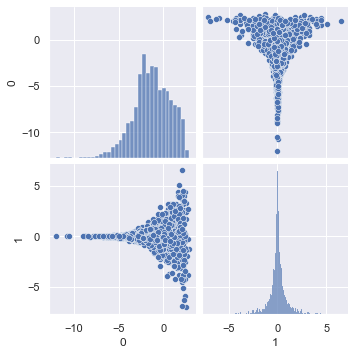

In [39]:
sns.pairplot(pd.DataFrame(xfi[0][:, 0:2]))

# Plotting

In [40]:
dlmc.interface.flow

SINF(
  (layer): ModuleList(
    (0): SlicedTransport(
      (transform1D): RQspline()
    )
    (1): SlicedTransport(
      (transform1D): RQspline()
    )
    (2): SlicedTransport(
      (transform1D): RQspline()
    )
    (3): SlicedTransport(
      (transform1D): RQspline()
    )
    (4): SlicedTransport(
      (transform1D): RQspline()
    )
    (5): SlicedTransport(
      (transform1D): RQspline()
    )
    (6): SlicedTransport(
      (transform1D): RQspline()
    )
  )
)

In [41]:
def sns_pairplot(q_samples, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(truth_samples)] = truth_label
        labels[len(truth_samples):] = q_label
        x_samples = np.concatenate([truth_samples, q_samples])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, common_norm=False, levels=levels)
    g.map_offdiag(sns.scatterplot, size=0.01, alpha=0.3)
    #g.map_offdiag(sns.kdeplot, common_norm=False, levels=levels, bw=0.4)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name, dpi=300)

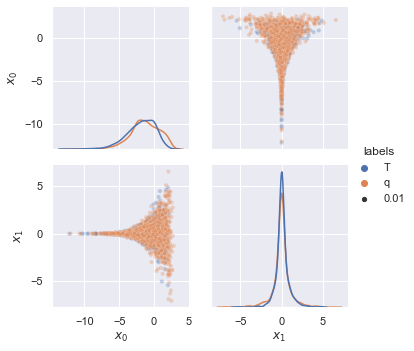

In [42]:
sns_pairplot(xfi[0][:, np.array([0, 1])], ix[:1000, np.array([0, 1])], levels=5,
             out_name='./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/funnel_corner_plot.png')

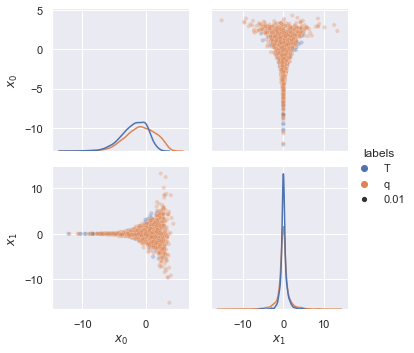

In [43]:
x = xfi[1]['10'][:, np.array([0, 1])]
sns_pairplot(x, ix[:1000, np.array([0, 1])], levels=5)

# Bias analysis

In [44]:
hmc_data = az.from_netcdf('./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/inference_data_funnel_centered_mcmc.nc')

In [45]:
hmc_steps = hmc_data['sample_stats']['n_steps'].to_numpy()
hmc_theta = hmc_data['posterior']['theta'].to_numpy()
print(hmc_theta.shape)
hmc_z = hmc_data['posterior']['z'].to_numpy()
print(hmc_z[0, :, :].shape)
hmc_samples = np.concatenate([hmc_theta[0, :].reshape(len(hmc_theta[0, :]), 1), hmc_z[0, :, :]], axis=1)

(10, 50000)
(50000, 100)


(array([109]),)


[]

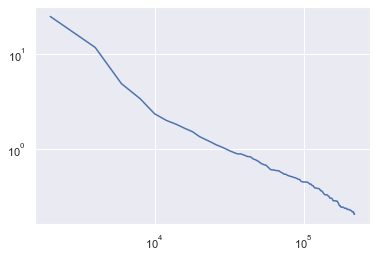

In [46]:
dlmc_bias_sq = []
for i in range(0, len(xfi[1].keys()) - 1):
    dlmc_var = np.var(xfi[1][f'{i}'].numpy(), axis=0)
    hmc_var = np.var(ix, axis=0)
    bias2 = (np.sqrt(dlmc_var) - np.sqrt(hmc_var)) ** 2 / hmc_var
    dlmc_bias_sq.append(np.mean(bias2))
n_calls = 2000 * np.ones(len(dlmc_bias_sq))
n_calls = np.cumsum(n_calls)
#n_calls -= 404

print(np.where(np.array(dlmc_bias_sq) == np.amin(np.array(dlmc_bias_sq))))

plt.plot(n_calls, np.array(dlmc_bias_sq))
plt.loglog()

(array([108]),)


[]

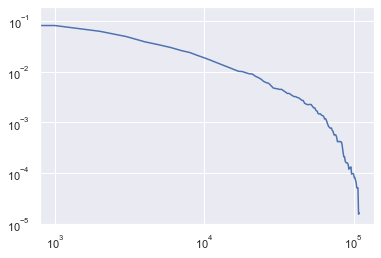

In [47]:
dlmc_bias_sq = []
for i in range(0, len(xfi[1].keys()) - 1):
    dlmc_var = np.var(xfi[1][f'{i}'].numpy(), axis=0)
    hmc_var = np.var(ix, axis=0)
    bias2 = (np.sqrt(dlmc_var) - np.sqrt(hmc_var)) ** 2 / hmc_var
    dlmc_bias_sq.append(bias2[0])
n_calls = 1000 * np.ones(len(dlmc_bias_sq))
n_calls = np.cumsum(n_calls)
n_calls -= 1000

print(np.where(np.array(dlmc_bias_sq) == np.amin(np.array(dlmc_bias_sq))))

plt.plot(n_calls, np.array(dlmc_bias_sq))
plt.loglog()

(array([47]),)


[]

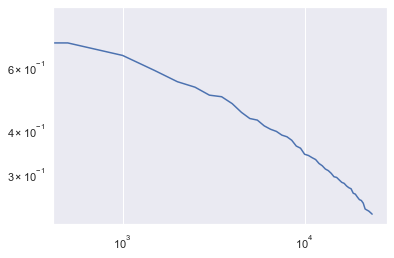

In [52]:
dlmc_bias_sq = []
for i in range(0, len(xfi[1].keys()) - 1):
    dlmc_mu = np.mean(xfi[1][f'{i}'].numpy(), axis=0)
    hmc_mu = np.mean(ix, axis=0)
    bias2 = (dlmc_mu - hmc_mu) ** 2 / hmc_mu ** 2
    dlmc_bias_sq.append(bias2[0])
n_calls = 500 * np.ones(len(dlmc_bias_sq))
n_calls = np.cumsum(n_calls)
n_calls -= 500

print(np.where(np.array(dlmc_bias_sq) == np.amin(np.array(dlmc_bias_sq))))

plt.plot(n_calls, np.array(dlmc_bias_sq))
plt.loglog()

(array([47]),)


[]

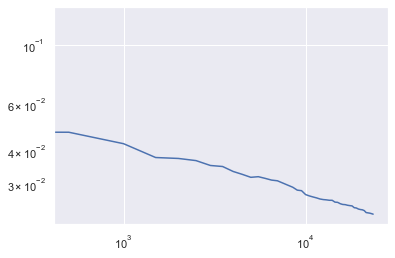

In [53]:
dlmc_bias_sq = []
for i in range(0, len(xfi[1].keys()) - 1):
    dlmc_mu = np.mean(xfi[1][f'{i}'].numpy(), axis=0)
    hmc_mu = np.mean(ix, axis=0)
    bias2 = (dlmc_mu - hmc_mu) ** 2
    dlmc_bias_sq.append(np.mean(bias2))
n_calls = 500 * np.ones(len(dlmc_bias_sq))
n_calls = np.cumsum(n_calls)
n_calls -= 500

print(np.where(np.array(dlmc_bias_sq) == np.amin(np.array(dlmc_bias_sq))))

plt.plot(n_calls, np.array(dlmc_bias_sq))
plt.loglog()

[-0.009242964]
0.0012053642


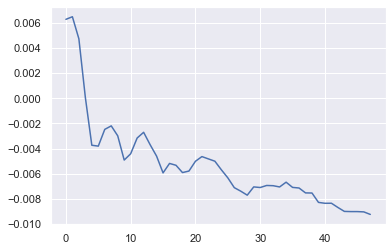

In [54]:
dlmc_mu = []
for i in range(0, len(xfi[4].keys()) - 1):
    dlmc_mu.append(np.mean(xfi[4][f'{i}'].numpy()))
n_calls = 404 * np.ones(len(dlmc_mu))
n_calls = np.cumsum(n_calls)
n_calls -= 404

print(dlmc_mu[-1:])
print(np.mean(hmc_mu))

plt.plot(np.arange(len(dlmc_mu)), np.array(dlmc_mu))
#plt.xscale('log')

0.78752965


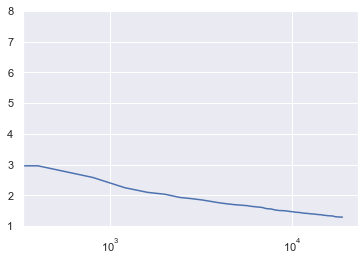

In [55]:
dlmc_var = []
for i in range(0, len(xfi[3].keys()) - 1):
    dlmc_var.append(np.mean(np.sqrt(xfi[3][f'{i}'].numpy())))
n_calls = 404 * np.ones(len(dlmc_var))
n_calls = np.cumsum(n_calls)
n_calls -= 404

print(np.mean(np.sqrt(hmc_var)))

plt.plot(n_calls, np.array(dlmc_var))
plt.xscale('log')

# Paper bias plots

In [79]:
num_runs = 10

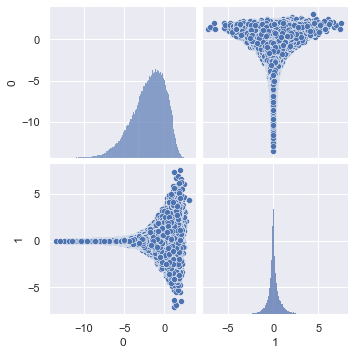

In [80]:
hmc_data = az.from_netcdf('./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/inference_data_funnel_centered_mcmc.nc')
#tuning_data = hmc_data = az.from_netcdf('./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/inference_data_funnel_centered_warmup.nc')
idata = az.from_netcdf('./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/new_inference_data_funnel_non_centered_mcmc.nc')

tuning_steps = np.loadtxt('./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/funnel_centered_warmup_n_steps.txt')

hmc_steps = hmc_data['sample_stats']['n_steps'].to_numpy()
hmc_theta = hmc_data['posterior']['theta'].to_numpy()
hmc_z = hmc_data['posterior']['z'].to_numpy()

nc_steps = idata['sample_stats']['n_steps'].to_numpy()
nc_theta = idata['posterior']['theta'].to_numpy()
nc_z = idata['posterior']['z'].to_numpy()
nc_theta = nc_theta.reshape(num_runs * nc_theta.shape[1], 1)
nc_z = nc_z.reshape(num_runs * nc_z.shape[1], nc_z.shape[2])

nc_samples = np.concatenate([nc_theta, nc_z], axis=1)
hmc_samples = np.concatenate([hmc_theta.reshape(hmc_theta.shape[0], hmc_theta.shape[1], 1),
                              hmc_z], axis=2)

nc_ref_var = np.var(nc_samples, axis=0)
sns.pairplot(pd.DataFrame(nc_samples[:, 0:2]))

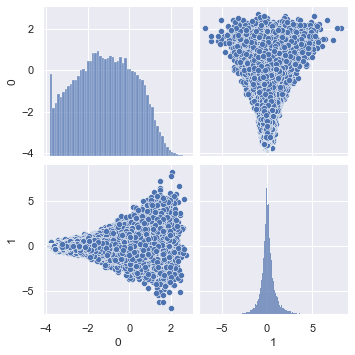

In [81]:
sns.pairplot(pd.DataFrame(hmc_samples[0, :, 0:2]))

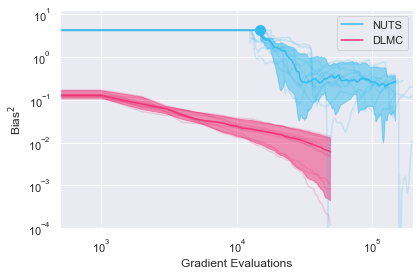

In [90]:
total_tuning = np.sum(tuning_steps, axis=1)
mean_total_tuning = np.mean(total_tuning)

max_nuts = 5000
num_dlmc = 50

all_c_bias_sq = np.empty((num_runs, max_nuts))
all_c_cum_steps = np.empty((num_runs, max_nuts))
all_tuning_steps = np.empty((num_runs, 500))

all_dlmc_bias_sq = np.empty((num_runs, num_dlmc))

plt.figure()
sns.set_theme()
for i in range(num_runs):
    
    all_c_cum_steps[i, :] = np.cumsum(hmc_steps[i, :max_nuts])
    all_tuning_steps[i, :] = np.cumsum(tuning_steps[i, :])
    c_cum_steps = np.cumsum(np.concatenate([tuning_steps[i, :], hmc_steps[i, :max_nuts]]))
    c_bias_sq = []
    for j in range(1, max_nuts + 1):
        iter_var = np.var(hmc_samples[i, :j, :], axis=0)
        hmc_bias_sq = (np.sqrt(iter_var) - np.sqrt(nc_ref_var)) ** 2
        c_bias_sq.append(hmc_bias_sq[0])
    c_bias_sq = np.array(c_bias_sq)
    all_c_bias_sq[i, :] = c_bias_sq
    c_bias_sq = np.concatenate([c_bias_sq[0] * np.ones(len(tuning_steps[i, :])), c_bias_sq])
        
    with open(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/dlmc_run_{i}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, num_dlmc):
        if k == 0:
            dlmc_var = np.var(dlmc_x[1]['init'].numpy(), axis=0)
        else:
            dlmc_var = np.var(dlmc_x[1][f'{k - 1}'].numpy(), axis=0)
        bias2 = (np.sqrt(dlmc_var) - np.sqrt(nc_ref_var)) ** 2 / nc_ref_var
        dlmc_bias_sq.append(bias2[0])
    all_dlmc_bias_sq[i, :] = np.array(dlmc_bias_sq)
    dlmc_steps = 1000 * np.ones(num_dlmc)
    dlmc_steps = np.cumsum(dlmc_steps) - 1000
    
    plt.plot(c_cum_steps, c_bias_sq, color='#33BBEE', alpha=0.2)
    plt.plot(dlmc_steps, np.array(dlmc_bias_sq), color='#EE3377', alpha=0.2)

mean_tuning_steps = np.median(all_tuning_steps, axis=0)
mean_c_cum_steps = np.median(all_c_cum_steps, axis=0) + mean_tuning_steps[-1:]
mean_nuts_steps = np.concatenate([mean_tuning_steps, mean_c_cum_steps])
mean_c_bias_sq = np.median(all_c_bias_sq, axis=0)
mean_nuts_bias_sq = np.concatenate([mean_c_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    mean_c_bias_sq])

low_c_bias_sq = np.percentile(all_c_bias_sq, 5, axis=0)
high_c_bias_sq = np.percentile(all_c_bias_sq, 95, axis=0)
low_nuts_bias_sq = np.concatenate([low_c_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                   low_c_bias_sq])
high_nuts_bias_sq = np.concatenate([high_c_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    high_c_bias_sq])

mean_dlmc_bias_sq = np.median(all_dlmc_bias_sq, axis=0)
low_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 5, axis=0)
high_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 95, axis=0)
    
plt.plot(mean_nuts_steps, mean_nuts_bias_sq, label='NUTS', color='#33BBEE')
plt.plot(dlmc_steps, mean_dlmc_bias_sq, label='DLMC', color='#EE3377')
plt.plot(mean_tuning_steps[-1:], mean_c_bias_sq[0], marker='o', markersize=10, color='#33BBEE')
plt.fill_between(mean_nuts_steps, low_nuts_bias_sq, high_nuts_bias_sq, color='#33BBEE', alpha=0.5)
plt.fill_between(dlmc_steps, low_dlmc_bias_sq, high_dlmc_bias_sq, color='#EE3377', alpha=0.5)
    
plt.loglog()
plt.legend(loc='upper right')
plt.xlim(500, 2e5)
plt.ylim(1e-4)
plt.ylabel(r'Bias$^2$')
plt.xlabel('Gradient Evaluations')
plt.tight_layout()
plt.savefig(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/bias2_funnel_sigma5_95percentiles.png', dpi=300)

In [ ]:
total_tuning = np.sum(tuning_steps, axis=1)
mean_total_tuning = np.mean(total_tuning)

max_nuts = 5000
num_dlmc = 20

all_c_bias_sq = np.empty((num_runs, max_nuts))
all_c_cum_steps = np.empty((num_runs, max_nuts))
all_tuning_steps = np.empty((num_runs, 500))

all_dlmc_bias_sq = np.empty((num_runs, num_dlmc))

plt.figure()
sns.set_theme()
for i in range(num_runs):
    
    all_c_cum_steps[i, :] = np.cumsum(hmc_steps[i, :max_nuts])
    all_tuning_steps[i, :] = np.cumsum(tuning_steps[i, :])
    c_cum_steps = np.cumsum(np.concatenate([tuning_steps[i, :], hmc_steps[i, :max_nuts]]))
    c_bias_sq = []
    for j in range(1, max_nuts + 1):
        iter_var = np.var(hmc_samples[i, :j, :], axis=0)
        hmc_bias_sq = (np.sqrt(iter_var) - np.sqrt(nc_ref_var)) ** 2
        c_bias_sq.append(np.mean(hmc_bias_sq))
    c_bias_sq = np.array(c_bias_sq)
    all_c_bias_sq[i, :] = c_bias_sq
    c_bias_sq = np.concatenate([c_bias_sq[0] * np.ones(len(tuning_steps[i, :])), c_bias_sq])
        
    with open(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/dlmc_run_{i}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, num_dlmc):
        if k == 0:
            dlmc_var = np.var(dlmc_x[1]['init'].numpy(), axis=0)
        else:
            dlmc_var = np.var(dlmc_x[1][f'{k - 1}'].numpy(), axis=0)
        bias2 = (np.sqrt(dlmc_var) - np.sqrt(nc_ref_var)) ** 2
        dlmc_bias_sq.append(np.mean(bias2))
    all_dlmc_bias_sq[i, :] = np.array(dlmc_bias_sq)
    dlmc_steps = 1000 * np.ones(num_dlmc)
    dlmc_steps = np.cumsum(dlmc_steps) - 1000
    
    plt.plot(c_cum_steps, c_bias_sq, color='#33BBEE', alpha=0.2)
    plt.plot(dlmc_steps, np.array(dlmc_bias_sq), color='#EE3377', alpha=0.2)

mean_tuning_steps = np.median(all_tuning_steps, axis=0)
mean_c_cum_steps = np.median(all_c_cum_steps, axis=0) + mean_tuning_steps[-1:]
mean_nuts_steps = np.concatenate([mean_tuning_steps, mean_c_cum_steps])
mean_c_bias_sq = np.median(all_c_bias_sq, axis=0)
mean_nuts_bias_sq = np.concatenate([mean_c_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    mean_c_bias_sq])

low_c_bias_sq = np.percentile(all_c_bias_sq, 5, axis=0)
high_c_bias_sq = np.percentile(all_c_bias_sq, 95, axis=0)
low_nuts_bias_sq = np.concatenate([low_c_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                   low_c_bias_sq])
high_nuts_bias_sq = np.concatenate([high_c_bias_sq[0] * np.ones(len(mean_tuning_steps)),
                                    high_c_bias_sq])

mean_dlmc_bias_sq = np.median(all_dlmc_bias_sq, axis=0)
low_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 5, axis=0)
high_dlmc_bias_sq = np.percentile(all_dlmc_bias_sq, 95, axis=0)
    
plt.plot(mean_nuts_steps, mean_nuts_bias_sq, label='NUTS', color='#33BBEE')
plt.plot(dlmc_steps, mean_dlmc_bias_sq, label='DLMC', color='#EE3377')
plt.plot(mean_tuning_steps[-1:], mean_c_bias_sq[0], marker='o', markersize=10, color='#33BBEE')
plt.fill_between(mean_nuts_steps, low_nuts_bias_sq, high_nuts_bias_sq, color='#33BBEE', alpha=0.5)
plt.fill_between(dlmc_steps, low_dlmc_bias_sq, high_dlmc_bias_sq, color='#EE3377', alpha=0.5)
    
plt.loglog()
plt.legend(loc='upper right')
plt.xlim(500, 2e5)
plt.ylabel(r'Bias$^2$')
plt.xlabel('Gradient Evaluations')
plt.tight_layout()
plt.savefig(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/bias2_funnel_sigma5_95percentiles.png', dpi=300)

In [ ]:
plt.figure()
for i in range(num_runs):
    
    c_cum_steps = np.cumsum(hmc_steps[i, :])
    c_bias_sq = []
    for j in range(1, len(hmc_samples[i]) + 1):
        iter_var = np.var(hmc_samples[i, :j, :], axis=0)
        hmc_bias_sq = (np.sqrt(iter_var) - np.sqrt(nc_ref_var)) ** 2 / nc_ref_var
        c_bias_sq.append(np.mean(hmc_bias_sq))
    c_bias_sq = np.array(c_bias_sq)
        
    with open(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/dlmc_run_{i}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, len(dlmc_x[1].keys())):
        if k == 0:
            dlmc_var = np.var(dlmc_x[1]['init'].numpy(), axis=0)
        else:
            dlmc_var = np.var(dlmc_x[1][f'{k - 1}'].numpy(), axis=0)
        bias2 = (np.sqrt(dlmc_var) - np.sqrt(nc_ref_var)) ** 2 / nc_ref_var
        dlmc_bias_sq.append(np.mean(bias2))
    dlmc_steps = 1000 * np.ones(len(dlmc_x[1].keys()))
    dlmc_steps = np.cumsum(dlmc_steps) - 1000
    
    plt.plot(c_cum_steps, c_bias_sq, label='NUTS', color='#33BBEE', alpha=0.5)
    plt.plot(dlmc_steps, np.array(dlmc_bias_sq), label='DLMC', color='#EE3377', alpha=0.5)

#plt.yscale('log')
plt.loglog()
#plt.legend(loc='upper right')
plt.ylabel(r'Bias$^2$')
plt.xlabel('Gradient Evaluations')
plt.savefig(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/bias2_rough.png')

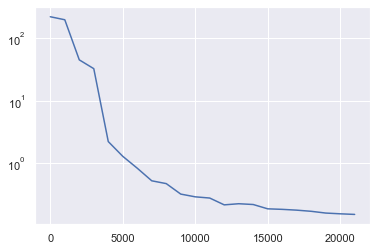

In [20]:
for i in [3]:

    with open(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/dlmc_run_{i}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
    
    dlmc_bias_sq = []
    for k in range(0, len(dlmc_x[1].keys())):
        if k == 0:
            dlmc_var = np.var(dlmc_x[1]['init'].numpy(), axis=0)
        else:
            dlmc_var = np.var(dlmc_x[1][f'{k - 1}'].numpy(), axis=0)
        bias2 = (np.sqrt(dlmc_var) - np.sqrt(nc_ref_var)) ** 2 / nc_ref_var
        dlmc_bias_sq.append(np.mean(bias2))
    dlmc_steps = 1000 * np.ones(len(dlmc_x[1].keys()))
    dlmc_steps = np.cumsum(dlmc_steps) - 1000

    plt.plot(dlmc_steps, np.array(dlmc_bias_sq))
plt.yscale('log')

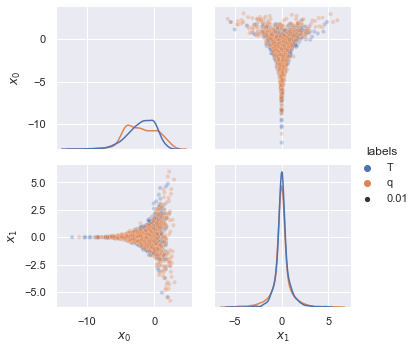

In [27]:
i = 1

with open(f'./dlmc_grad_experiments/benchmarks/funnel_sigma5/nuts/dlmc_run_{i}.pkl', 'rb') as f:
        dlmc_x = pickle.load(f)
        
sns_pairplot(dlmc_x[0][:, 0:2], ix[:, 0:2][:1000])